In [116]:
import sys
try:
    del sys.modules["spnhelp"]
except:
    pass
import spnhelp
try:
    del sys.modules["clg_revised"]
except:
    pass
from clg_revised import noise, Norm
from math import sqrt
from spn.io.Text import spn_to_str_equation
import pandas as pd
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
import numpy as np
import matplotlib.pyplot as plt
from spn.algorithms.Marginalization import marginalize
from spn.algorithms.Inference import likelihood
import scipy.stats as stats

     X    Y    Z    J
X  1.0  0.0  1.0  1.0
Y  0.0  1.0  1.0  2.0
Z  1.0  1.0  3.0  4.0
J  1.0  2.0  4.0  7.0


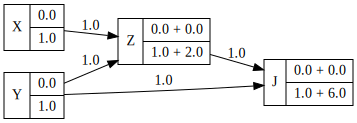

In [117]:

W = "X" @ noise
X = "X" @ noise
Y = "Y" @ noise
Z = "Z" @ (X + Y + noise)
J = "J" @ (Z + noise + Y)

K = "K" @ noise
L = "L" @ (K + noise)

# Z & L
print(X.get_Σ())
# samples = X.forward_sample(10000)
# print(np.cov(samples, rowvar=False))
X.get_graph(True)

     Z    J
Z  3.0  3.0
J  3.0  7.0


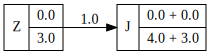

In [118]:
copy = X.deepcopy()
copy.castrate_roots()

print(copy.get_Σ())
np.linalg.inv(copy.get_Σ())
copy.get_graph(True)

[{A ~ N(0.0, 4.0)}, {K ~ N(0.0, 1.0)}]
[] making a gaussian leaf from A
[] making a gaussian leaf from K
(Gaussian(V0|mean=0.0;stdev=2.0) * Gaussian(V1|mean=0.0;stdev=1.0))


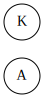

In [119]:
from itertools import product
from spn.structure.Base import Node, Sum, Product, assign_ids, rebuild_scopes_bottom_up

def pgm_to_spn(pgm : Norm, eps = 0.1, name_map = None):

    pgm.__recompute_params__()

    # name mapping:
    if name_map == None:
        name_map = {name : i for i, name in enumerate(pgm.get_scope(across_factors = True))}

    root_clusters = pgm.cluster_roots_by_dependence()
    print(root_clusters)
    
    global_factors = []

    for p in root_clusters:
        roots = list(p)

        if len(roots) == 1 and roots[0].children == []:
            print("[] making a gaussian leaf from", roots[0].name)
            global_factors.append(Gaussian(mean=roots[0].current_mean, stdev=roots[0].current_sd, scope = name_map[roots[0].name]))

        else:
            names = [n.name for n in roots]
            print("[] discretizing", names, "and generating cartesian product")
                        
            discs = [spnhelp.gauss_discretization_params(n.current_mean, n.current_sd, eps, spnhelp.split_until_at_most_eps_wide) for n in roots]
            
            summands = []
            sum_weights = []

            
            

            for vals in product(*discs): # for each possible assignment of the cells of the roots (cartesian product)
                sub_factor = []
                sum_weight = 1
                copy = roots[0].deepcopy()
                copy_roots = copy.get_roots()
                
                for i, v in enumerate(vals): # condition each root on the assignment
                    start, mid, end, weight = v
                    print("[] set", roots[i].name, "to", v[1])

                    roots[i].condition(mid, recompute_covariance_and_mean=False) # don't recompute the covariance and mean yet

                    sub_factor += Uniform(start=start, end=end, scope = name_map[roots[i].name]),
                    sum_weight *= weight
            
                roots[0].__recompute_params__() # recompute the covariance matrix and means here

                # now, get the pgm of the children.
                child = roots[0].castrate_roots()
                sub_factor += pgm_to_spn(child, eps = eps, name_map = name_map),

                summands += Product(sub_factor),
                sum_weights += sum_weight,
            
            s = Sum(summands, sum_weights)
            assign_ids(s)
            rebuild_scopes_bottom_up(s)

            global_factors.append(s)


    prod = Product(global_factors)
    assign_ids(prod)
    rebuild_scopes_bottom_up(prod)
    return prod

A = "A" @ (2*noise)
K = "K" @ (1*noise)

A & K 
# B = "B" @ (A + noise)

spn = pgm_to_spn(A, eps = 2)

from spn.io.Text import spn_to_str_equation
print(spn_to_str_equation(spn))
A.get_graph()

In [120]:
samples = spnhelp.sample_from_spn(spn, 100000)
np.cov(samples, rowvar=False)

array([[4.01438612, 0.00791849],
       [0.00791849, 0.996837  ]])

[1532919076640, 1532919082256, 1532919086336, 1532919078080]
[1532919079472, 1532923843280, 1532923838672]
[1532923841936, 1532923854752]


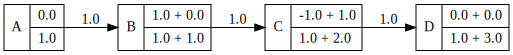

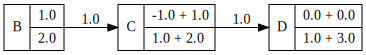

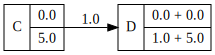

In [126]:
A = "A" @ noise
"D" @ ("C" @ ("B" @ (A + noise + 1) + noise - 1) + noise)
# "C" @ (A + noise)
# "D" @ (A + noise)

print(list(map(lambda n: id(n) , A.get_nodes())))
B = A.deepcopy().castrate_roots()
print(list(map(lambda n: id(n) , B.get_nodes())))
C = B.deepcopy().castrate_roots()
print(list(map(lambda n: id(n) , C.get_nodes())))

g1 = A.get_graph(True)
g2 = B.get_graph(True)
g3 = C.get_graph(True)

# show graphviz graphs
from IPython.display import Image, display
display(g1)
display(g2)
display(g3)